In [1]:
%load_ext autoreload
%autoreload 2

# imports


In [2]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import pickle
from tools import get_mids, array_source_interp
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2

from fluxes import atmo_background
from fluxes import astro_flux
from settings import ngc1068
from scipy.interpolate import RegularGridInterpolator


matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
warnings.filterwarnings("ignore")

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# loading effective areas


In [3]:
sindec_bins, logE_bins, aeffs = pd.read_pickle("../resources/aeff_cluster_nuecc_with-eq.pickle")


## binning

In [4]:
aeff_test = aeffs.iloc[0]["equatorial"] # for testing
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
39 declination bins


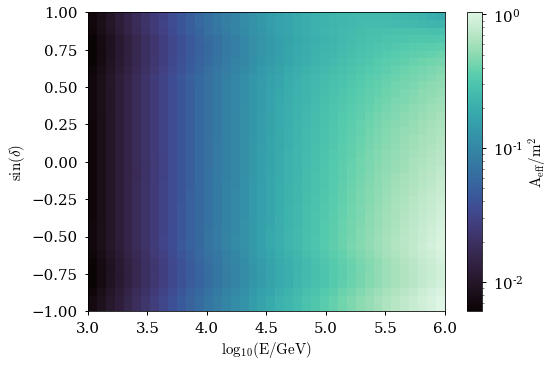

In [5]:
plt.pcolormesh(logE_bins, sindec_bins, aeff_test.T * 1E-4, norm=LogNorm())
plt.xlabel(r"$\rm log_{10} (E/GeV)$")
plt.ylabel(r"$\rm sin(\delta)$")
cb = plt.colorbar()
cb.set_label(r"$\rm A_{eff} / m^2$")


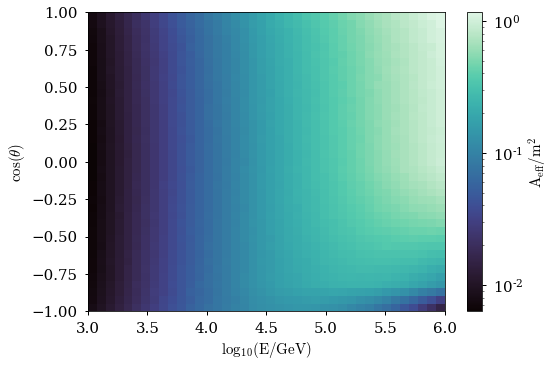

In [6]:
plt.pcolormesh(logE_bins, sindec_bins, aeffs.iloc[0]["aeff_hist"], norm=LogNorm())
plt.xlabel(r"$\rm log_{10} (E/GeV)$")
plt.ylabel(r"$\rm cos(\theta)$")
cb = plt.colorbar()
cb.set_label(r"$\rm A_{eff} / m^2$")



# background

In [7]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# load total nue+nuebar + nutau+nutaubar
# (nutau+nutaubar is practically zero)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["nue_total"] + flux_def["nutau_pr"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

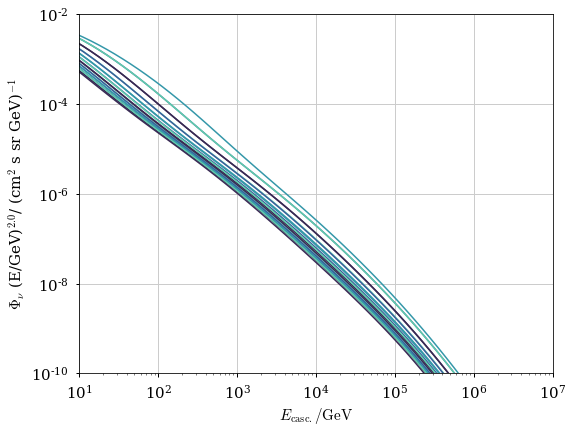

In [8]:
spec = 2.0
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    p0 = ax.loglog(
        e_grid,
        e_grid ** (spec) * flux_def["nue_conv"][:, ti],
        ls="solid",
        lw=1.5,
    )

ax.set_xlim(10, 1e7)
ax.set_ylim(1e-10, 1e-2)
ax.set_xlabel(r"$E_{\rm casc.} / {\rm GeV}$")
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "/ (cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


# NGC1068 - source parameters

In [9]:
# livetime of 10yr in seconds
LIVETIME = 365 * 10 * 24 * 3600
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 * 2 # numu + numubar -> nue+nuebar + nutau+nutaubar
E0_NGC = 1E3

# ngc flux error contour
# gamma_c_68, phi_c_68 = np.loadtxt("../resources/ngc_paper_68_contour.txt")
# phi_c_68 /= 1E11
# gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")

## calculate number of events for ngc-like source

In [10]:
delta_psi = 4
n_events = pd.read_pickle("../resources/casc_events_ngc.pickle")

In [11]:
n_events = []
for dec in np.arcsin(sindec_mids):
    for ind, row in aeffs.iterrows():
        dct = {"src_dec": dec, "src_sindec": np.sin(dec)}
        for nm, val in zip(aeffs.index.names, ind):
            dct[nm] = val
        aeff_factor_signal = (
            array_source_interp(dec, row["equatorial"], sindec_mids)
            * LIVETIME
            * ewidth
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            phi_0=PHI_NGC,
            smear_energy=False,
        )
        dct["n_sig"] = np.sum(k_s)

        aeff_factor_bckg = (
            array_source_interp(dec, row["equatorial"], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        )
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, spl_vals.T, sindec_mids).T,
            smear_energy=False,
        )
        dct["n_bg"] = np.sum(k_b)
        dct["s/sqb"] = dct["n_sig"] / np.sqrt(dct["n_bg"])
        n_events.append(dct)
n_events = pd.DataFrame(n_events)

pd.to_pickle(n_events, "../resources/casc_events_ngc.pickle")

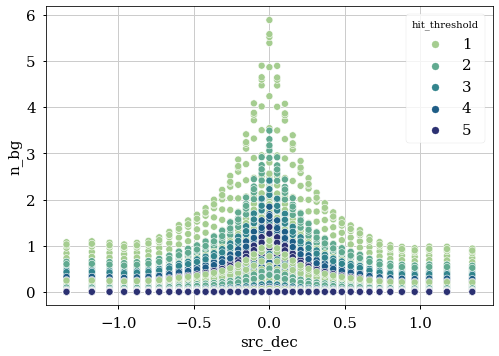

In [19]:
ax = sns.scatterplot(
    data=n_events, x="src_dec", y="n_bg", hue="hit_threshold", palette="crest"
)


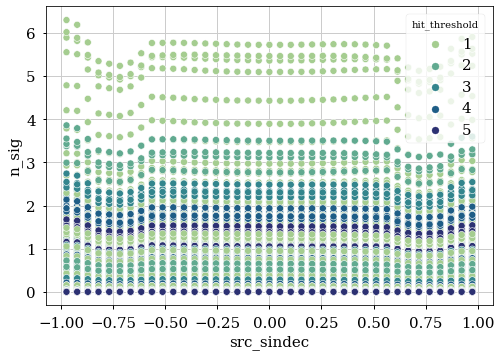

In [21]:
ax = sns.scatterplot(
    data=n_events, 
    x="src_sindec",
    y="n_sig",
    hue="hit_threshold",
    palette="crest",
)


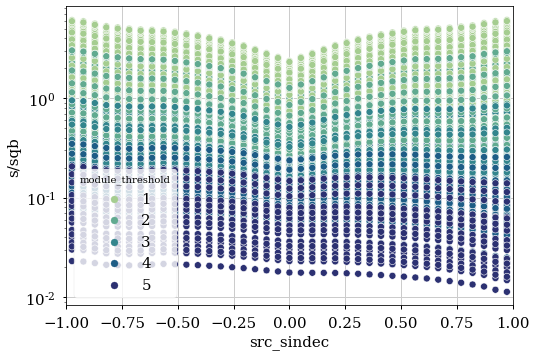

In [20]:
ax = sns.scatterplot(
    data=n_events, x="src_sindec", y="s/sqb", hue="module_threshold", palette="crest"
)
ax.set_xlim(-1, 1)
ax.set_yscale("log")


# simple PS fits at various decs

## energy and psi resolution

In [12]:
resolution_df = pd.read_pickle("../resources/optimization_resolutions.pickle")
resolution_df = resolution_df.set_index(["config", "spacing", "pmts"])


### llh definition

In [13]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    src_dec,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_b_base * x[0],
        array_source_interp(src_dec, spl_vals.T, sindec_mids).T,
        normed_kvals=normed_kvals,
    )
    mu_s = astro_flux(
        shape, mu_s_base, emids, e_0, *x[1:], phi_0=phi_0, normed_kvals=normed_kvals
    )
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


## point-source vs uniform atmospheric

### testing one config

In [14]:
i = 50
aeff_test = aeffs.iloc[i]["equatorial"] * 7 # full detector
config = aeffs.index[i]
c_names = np.asarray(aeffs.index.names)
# config is: 'full pessimistic cluster' and 16 PMTs for aeffs
print(aeffs.loc[config], c_names)
reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
print(reso_test.name)
bckg_grid = np.ones_like(reso_test.psi2)
bckg_grid /= np.sum(bckg_grid, axis=0)

aeff_hist     [[0.012907542558880266, 0.01597975130950434, 0...
equatorial    [[114.37128603830939, 115.41494100146402, 108....
Name: (1, 1, nan, 50.0), dtype: object ['hit_threshold' 'module_threshold' 'min_pos_resolution' 'spacing']
('Full pessimistic cluster', 50.0, 16)


LIVETIME: 10.0
source: NGC 1068
Asimov data sum: Background= 21.84711170285292 , Signal: 19.647493811888225
Atmo-only normalization: [1.89933486]
Signal fit parameters: [1.00004847 3.1999761  0.99998324]
-2 Delta LLH: 50.72299438826485
P-VALUE: 9.674793759064916e-12 SIGNIFICANCE: 6.811257501984538



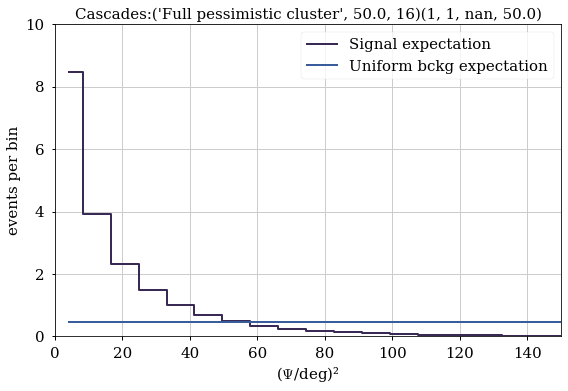

In [88]:
print("LIVETIME:", LIVETIME/3600/24/365)
print("source: NGC 1068")
aeff_factor_bckg = (
    array_source_interp(ngc1068.dec.rad, aeff_test, sindec_mids)
    * LIVETIME
    * ewidth
    * (np.deg2rad(delta_psi) ** 2)
    * np.pi  # solid angle approx.
) * bckg_grid

aeff_factor_signal = (
    array_source_interp(ngc1068.dec.rad, aeff_test, sindec_mids) * LIVETIME * ewidth * reso_test.psi2
)
# model expectation for fitting
mu_b_base = np.copy(aeff_factor_bckg)
mu_s_base = np.copy(aeff_factor_signal)

# asimov data
k_b = atmo_background(
    aeff_factor_bckg,
    array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
    normed_kvals=reso_test.energy_res,
)
k_s = astro_flux(
    "powerlaw",
    aeff_factor_signal,
    emids,
    E0_NGC,
    GAMMA_NGC,
    1,
    phi_0=PHI_NGC,
    normed_kvals=reso_test.energy_res,
)
k_i = k_s + k_b

print("Asimov data sum: Background=", np.sum(k_b), ", Signal:", np.sum(k_s))
# fix signal contribution to 0
fit_config = dict(
    mu_b_base=mu_b_base,
    mu_s_base=mu_s_base,
    k_i=k_i,
    e_0=E0_NGC,
    phi_0=PHI_NGC,
    shape="powerlaw",
    normed_kvals=reso_test.energy_res,
    src_dec=ngc1068.dec.rad,
)
local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), **fit_config)
global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 3.0, 1.2),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
print("")

psi2_mids = get_mids(reso_test.psi2_bins)
plt.figure()
plt.title("Cascades:"+str(reso_test.name)+str(config))
plt.plot(psi2_mids, np.sum(k_s, axis=-1), ds="steps-mid", label="Signal expectation")
plt.plot(
    psi2_mids, np.sum(k_b, axis=-1), ds="steps-mid", label="Uniform bckg expectation"
)
plt.xlabel(r"($\Psi$/deg)²")
plt.ylabel("events per bin")
plt.xlim(0, 150)
plt.ylim(0, 10)
plt.legend()
plt.tight_layout()


# Full PS setup

In [98]:
config, c_names

((5, 5, 5.0, 200.0),
 array(['hit_threshold', 'module_threshold', 'min_pos_resolution',
        'spacing'], dtype='<U18'))

In [15]:
c_names = np.asarray(aeffs.index.names)
mask = aeffs.index.get_level_values("spacing") >= 50

ps_significances = []

for config, aeff in aeffs.loc[mask].iterrows():
    # aeff *= 7 # full detector
    tmp = {key:val for key, val in zip(c_names, config)}
    aeff_test = aeff["equatorial"]
    reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
    bckg_grid = np.ones_like(reso_test.psi2)
    bckg_grid /= np.sum(bckg_grid, axis=0)
    aeff_factor_bckg = (
        array_source_interp(ngc1068.dec.rad, aeff_test, sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid

    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff_test, sindec_mids) * LIVETIME * ewidth * reso_test.psi2
    )
    # model expectation for fitting
    mu_b_base = np.copy(aeff_factor_bckg)
    mu_s_base = np.copy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
        normed_kvals=reso_test.energy_res,
    )
    k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        phi_0=PHI_NGC,
        normed_kvals=reso_test.energy_res,
    )
    k_i = k_s + k_b

    tmp["nb"] = np.sum(k_b)
    tmp["ns"] = np.sum(k_s)
    
    # fix signal contribution to 0
    fit_config = dict(
        mu_b_base=mu_b_base,
        mu_s_base=mu_s_base,
        k_i=k_i,
        e_0=E0_NGC,
        phi_0=PHI_NGC,
        shape="powerlaw",
        normed_kvals=reso_test.energy_res,
        src_dec=ngc1068.dec.rad,
    )
    local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), **fit_config)
    global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.2,),
        approx_grad=True,
    )
    tmp["out_bg"] = out_bckg[0]

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.2, 3.0, 1.2),
        approx_grad=True,
    )
    tmp["out_sig"] = out_comp[0]
    tmp["-2DLLH"] =  out_bckg[1] - out_comp[1]

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = erfinv(1 - pval) * np.sqrt(2)
    tmp["pval"] = pval
    tmp["sigma"] = significance
    ps_significances.append(tmp)
ps_significances = pd.DataFrame(ps_significances)
ps_significances["comb_threshold"] = np.asarray(
    ps_significances.hit_threshold
    + ps_significances.module_threshold * 10,
    dtype=int,
)


In [16]:
ps_significances["sigma_cut"] = 7
ps_significances.loc[
    ps_significances["sigma"] <= 7, "sigma_cut"
] = ps_significances.loc[ps_significances["sigma"] <= 7, "sigma"]


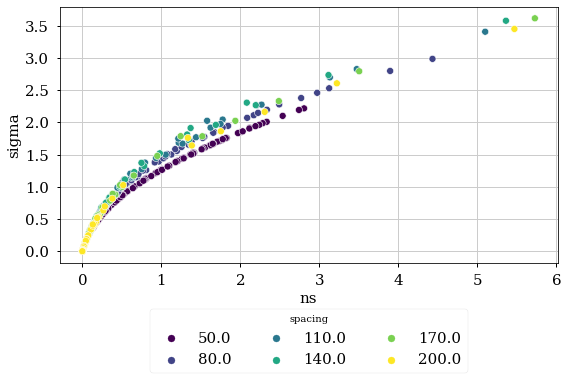

In [17]:
selection = ps_significances #.loc[ps_significances.sigma >= 2]
ax = sns.scatterplot(
    data=selection,
    x="ns",
    y="sigma",
    hue="spacing",
    #hue="comb_threshold",
    palette="viridis",
)
ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.15), title="spacing")
plt.tight_layout()


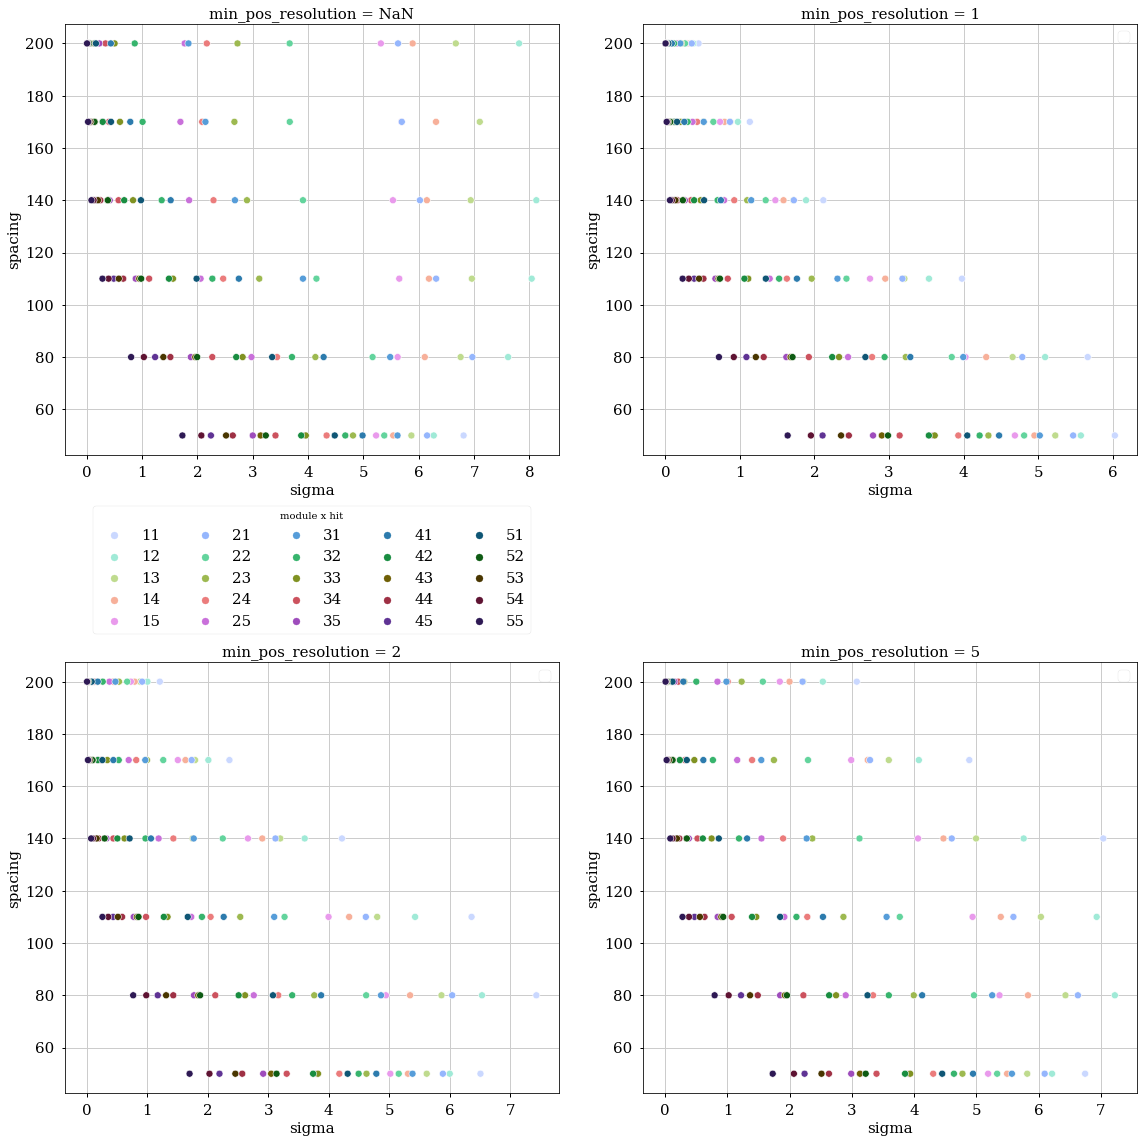

In [183]:
f, axes = plt.subplots(figsize=(16, 16), ncols=2, nrows=2)
ax = sns.scatterplot(
    data=ps_significances.loc[ps_significances.min_pos_resolution.isna()],
    x="sigma",
    y="spacing",
    hue="comb_threshold",
    palette=sns.cubehelix_palette(rot=7, n_colors=25, hue=1.5),
    ax=axes[0][0]
)
ax.legend(
    ncol=5, loc="upper center", bbox_to_anchor=(0.5, -0.1), title="module x hit"
)
ax.set_title("min_pos_resolution = NaN")

ax = sns.scatterplot(
    data=ps_significances.loc[ps_significances.min_pos_resolution == 1],
    x="sigma",
    y="spacing",
    hue="comb_threshold",
    palette=sns.cubehelix_palette(rot=7, n_colors=25, hue=1.5),
    ax=axes[0][1]
)
ax.legend("")
ax.set_title("min_pos_resolution = 1")

ax = sns.scatterplot(
    data=ps_significances.loc[ps_significances.min_pos_resolution == 2],
    x="sigma",
    y="spacing",
    hue="comb_threshold",
    palette=sns.cubehelix_palette(rot=7, n_colors=25, hue=1.5),
    ax=axes[1][0]
)
ax.legend("")
ax.set_title("min_pos_resolution = 2")

ax = sns.scatterplot(
    data=ps_significances.loc[ps_significances.min_pos_resolution == 5],
    x="sigma",
    y="spacing",
    hue="comb_threshold",
    palette=sns.cubehelix_palette(rot=7, n_colors=25, hue=1.5),
    ax=axes[1][1]
)
ax.legend("")
ax.set_title("min_pos_resolution = 5")

f.tight_layout()
